In [2]:
import pandas as pd
import numpy as np

#Import csv files and putting them in a dictionary
file_names = ["1.4.1", "1.2.3", "1.4.2", "1.3.2", "1.3.1", "1.2.2", "1.2.1", "1.1.1"]
file_names = ["1.1.1"]
votes = [pd.read_csv(file_name+".csv", index_col=0) for file_name in file_names]
votes_with_nan = [vote.where(vote<2) for vote in votes]
VOTE_DICTIONARY = dict(zip(file_names, votes_with_nan))

#Import Congress data
Congress = pd.read_csv("Congreso.csv", index_col=0)


In [3]:
Congress.loc[Congress["Grupo"] == "Partido Democrático Somos Perú", ["Grupo"]] = "Somos Perú"
Congress.loc[Congress["Grupo"] == "Alianza para el Progreso del Perú", ["Grupo"]] = "Alianza para el Progreso"


In [4]:
Congress["Grupo"].unique()

array(['Alianza para el Progreso', 'Partido Politico Nacional Perú Libre',
       'Fuerza Popular', 'Somos Perú', 'Acción Popular',
       'Avanza País - Partido de Integración Social', 'Podemos Perú',
       'Renovación Popular', 'Juntos por el Perú', 'Partido Morado'],
      dtype=object)

In [5]:
VOTOS = pd.concat(votes_with_nan, axis=1)
VOTOS

,VOTACIÓN DE LA ADMISIÓN A DEBATE DE LA MOCIÓN 12 477,VOTACIÓN DE LA ADMISIÓN A DEBATE DE LA MOCIÓN 12613,VOTACIÓN DE L TEXTO SUSTITUTORIO CONSENSUADO DE LAS MOCI ONES DE ORDEN DEL DÍA 12477 Y 12613,VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 8378,VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 8567,VOTACIÓN DE MODIFICACIONES AL CUADRO DE LA COMISIÓN PERMANENTE,VOTACIÓN DE LA ADMISIÓN A DEBATE DE LA MOCIÓN QUE PROPONE QUE EL,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LA MOCIÓN 12384,VOTACIÓN DE LA RATIFICACIÓN DEL ACUERDO DE LA JUNTA DE PORTAVOCES QUE EXONERA DEL DICTAMEN DE LA COMISIÓN DE EDUCACIÓN Y AMPLÍA LA AGENDA RESPECTO DE LOS PROYECTOS DE LEY 7931 Y 8063,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 7931 Y 8063,...,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 8002,VOTACIÓN DE LA EXONERACIÓN DE LA SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 8002,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 4099,VOTACIÓN DE LA EXONERACIÓN DE LA SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 4099,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 2729 Y OTROS,VOTACIÓN DE LA EXONERACIÓN DE LA SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 2729 Y OTROS,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO DE LEY DE ENDEUDAMIENTO DEL SECTOR PÚBLICO PARA EL AÑO FISCAL 2025 CON EXCEPCIÓN DE LA CUARTA DISPOSICIÓN COMPLEMENTARIA MODIFICATORIA (PROYECTO 8760),VOTACIÓN DE LA CUARTA DISPOSICIÓN COMPLEMENTARIA MODIFICATORIA DE L TEXTO SUSTITUTORIO DEL PROYECTO DE LEY DE ENDEUDAMIENTO DEL SECTOR PÚBLICO PARA EL AÑO FISCAL 2025 (PROYECTO 8760),VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO DE LEY DE EQUILIBRIO FINANCIERO DEL PRESUPUESTO DEL SECTOR PÚBLICO PARA EL AÑO FISCAL 2025 (PROYECTO 8759),VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO DE LEY DE PRESUPUESTO DEL SECTOR PÚBLICO PARA EL AÑO FISCAL 2025 (PROYECTO 8758)
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,NaN,NaN,1.0,1.0,1.0,NaN,-1.0,1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0
134,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
135,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN


In [6]:
def add_summary_row_single(df):
    # Compute the sum of votes for each column
    column_sums = df.sum(axis=0)
    
    # Determine if the bill passed (+1) or didn't (-1)
    passed_or_not = [1 if x > 0 else -1 for x in column_sums]
    
    # Add the summary row to the DataFrame
    df_with_summary = pd.concat(
        [df, pd.DataFrame([passed_or_not], columns=df.columns, index=["Summary"])],
        axis=0
    )
    return df_with_summary
VOTOS = add_summary_row_single(VOTOS)

In [7]:
def calculate_alignment(df):
    # Extract the summary row (outcomes)
    outcomes = df.loc["Summary"]
    
    # Drop the summary row from the DataFrame to analyze representatives
    representatives = df.drop("Summary")
    
    # Calculate alignment for each representative
    alignment_count = (representatives == outcomes).sum(axis=1)
    
    # Create a DataFrame to store results
    alignment_df = pd.DataFrame({
        "Representative": representatives.index,
        "Aligned": alignment_count
    })
    
    # Sort by number of correct guesses in descending order
    alignment_df = alignment_df.sort_values(by="Aligned", ascending=False).reset_index(drop=True)
    
    return alignment_df


In [8]:
pd.concat([calculate_alignment(VOTOS), Congress["Grupo"]], axis=1).groupby("Grupo").median().sort_values("Aligned")

,Representative,Aligned
Grupo,,
Partido Morado,114.0,186.0
Partido Politico Nacional Perú Libre,67.0,198.0
Renovación Popular,86.0,199.0
Juntos por el Perú,75.0,204.0
Acción Popular,69.5,204.5
Fuerza Popular,68.5,215.0
Somos Perú,54.0,217.0
Alianza para el Progreso,73.0,220.0
Podemos Perú,46.5,220.5


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
VOTOS_REDUCED = pca.fit_transform(VOTOS.fillna(0))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.1735152  0.1134482  0.05675053]
[55.91959499 45.2161998  31.9801292 ]


In [10]:
VOTOS_REDUCED_DF = pd.concat([pd.DataFrame(VOTOS_REDUCED), Congress], axis=1)
VOTOS_REDUCED_DF

,0,1,2,Congresista,Región,Bancada,Grupo,Votacion
0,4.369146,-3.251826,0.804628,Acuña Peralta María Grimaneza,Lambayeque,ALIANZA PARA EL PROGRESO,Alianza para el Progreso,"11,384"
1,-3.327954,-0.393233,-4.338902,Acuña Peralta Segundo Héctor,La libertad,HONOR Y DEMOCRACIA,Alianza para el Progreso,"19,729"
2,-2.635642,6.230078,6.028242,Agüero Gutiérrez María Antonieta,Arequipa,PERÚ LIBRE,Partido Politico Nacional Perú Libre,"29,293"
3,4.225801,-1.479934,-0.060913,Aguinaga Recuenco Alejandro Aurelio,Lambayeque,FUERZA POPULAR,Fuerza Popular,"10,715"
4,1.205188,-0.385420,0.456057,Alcarraz Aguero Yorel Kira,LIMA,PODEMOS PERÚ,Somos Perú,"28,404"
...,...,...,...,...,...,...,...,...
134,3.321666,-1.206635,-3.766459,Zeballos Aponte Jorge Arturo,Peruanos Residentes en el Extranjero,RENOVACIÓN POPULAR,Renovación Popular,"4,691"
135,-1.957129,1.956986,-4.052449,Zeballos Madariaga Carlos Javier,Puno,NO AGRUPADO,Acción Popular,"23,883"
136,0.350698,-1.196059,1.062065,Zegarra Saboya Ana Zadith,Loreto,SOMOS PERÚ,Somos Perú,"4,917"
137,2.543608,-0.945024,1.457619,Zeta Chunga Cruz María,Piura,FUERZA POPULAR,Fuerza Popular,"10,079"


In [11]:
VOTOS_REDUCED_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0            139 non-null    float64
 1   1            139 non-null    float64
 2   2            139 non-null    float64
 3   Congresista  138 non-null    object 
 4   Región       138 non-null    object 
 5   Bancada      138 non-null    object 
 6   Grupo        138 non-null    object 
 7   Votacion     138 non-null    object 
dtypes: float64(3), object(5)
memory usage: 8.8+ KB


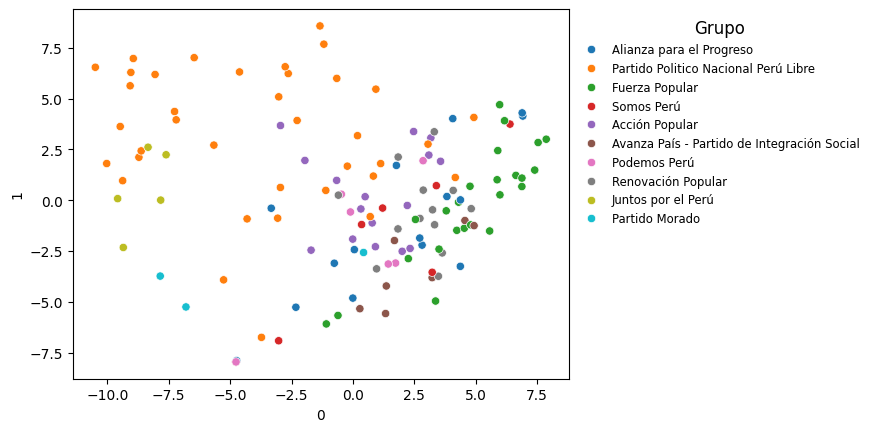

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

import seaborn as sns
from matplotlib import pyplot as plt

# Create scatterplot
sns.scatterplot(data = VOTOS_REDUCED_DF, x = 0, y = 1, hue = "Grupo")

# Adjust the legend
plt.legend(title='Grupo', bbox_to_anchor=(1, 1), loc='best', frameon=False, title_fontsize='large', fontsize='small', ncol=1)

# Display the plot
#plt.tight_layout()
plt.show()


In [15]:
import plotly.express as px

# Create scatterplot using Plotly
fig = px.scatter_3d(VOTOS_REDUCED_DF, x=0, y=1,z=2, color="Bancada",  hover_data={"Congresista": True})

# Adjust the legend to make it wider
fig.update_layout(
    legend_title="Bancada",
    legend=dict(
        title_font_size=15,
        font_size=10,
        itemsizing='constant',  # Ensure the legend items are sized uniformly
        orientation='v',  # Set legend to horizontal
        x=1.05,  # Move the legend outside of the plot
        y=1,     # Align it with the top of the plot
        xanchor='left',  # Anchor legend to the left of the plot area
    )
)

# Show the plot
fig.show()